### Graph Neural Network (GNN)

$$h_{i}^{t+1} = f\left(h_{i}^{t} W + \sum_{j \in N (i)} \frac{1}{C_{i,j}} h_{j}^{t} U \right)$$

Old representation times a weight matrix:
$$h_{i}^{t} W $$

Information from neighbors times a weight matrix:
$$h_{j}^{t} U $$

### Aggregation function:

Sum over all transformed neighbor representations

$$\sum_{j \in N (i)} \frac{1}{C_{i,j}}$$

Normalize the vectors differently for each neighbor
$$\frac{1}{C_{i,j}}$$

The sum is a $permutation-invariant$ aggregation function -> Insensitive to $order$

Each node's updated value becomes a weighting of its previous value+weightning of it's neighbors values.

-> Agg function can be mean, max, concatenation, etc.



Collapse $W_{self}$ and $W_{neigh}$ into $W$ by adding self-loops to the adjacency matrix $A$:
$$H^{(k+1)} = \sigma \left( (A+I)H^{(k)} W^{k+1} \right)$$

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.optim import SGD
from torch_geometric.data import Data
from torch_geometric.nn import GCNConv, Linear, GATConv

import torch_geometric.transforms as T
from torch_geometric.utils import to_undirected
from torchviz import make_dot

import networkx as nx
from networkx.classes.function import density, degree

import csv
import numpy as np
import matplotlib.pyplot as plt
plt.rcParams['figure.dpi'] = 360

### Graph dataset
<div style="text-align:center; display: flex; justify-content: center;">
  <table>
    <tr>
      <th>Rosette number</th>
      <th>Nodes</th>
      <th>Edges</th>
    </tr>
    <tr>
      <td>3</td>
      <td>11157</td>
      <td>7572</td>
    </tr>
    <tr>
      <td>6</td>
      <td>9568</td>
      <td>5245</td>
    </tr>
    <tr>
      <td>7</td>
      <td>11635</td>
      <td>9257</td>
    </tr>
    <tr>
      <td>11</td>
      <td>13667</td>
      <td>13051</td>
    </tr>
    <tr>
      <td>12</td>
      <td>10617</td>
      <td>6870</td>
    </tr>
    <tr>
      <td>13</td>
      <td>13260</td>
      <td>14395</td>
    </tr>
    <tr>
      <td>14</td>
      <td>10704</td>
      <td>7635</td>
    </tr>
    <tr>
      <td>15</td>
      <td>10131</td>
      <td>8655</td>
    </tr>
    <tr>
      <td>18</td>
      <td>11117</td>
      <td>7991</td>
    </tr>
    <tr>
      <td>19</td>
      <td>10248</td>
      <td>6689</td>
    </tr>
  </table>
</div>



In [2]:
def graph_r(r):

    nodes = []
    edges = []
    mass = []

    with open(f'./data/rosette{r}_nodes.csv', mode='r') as csv_file:
        csv_reader = csv.DictReader(csv_file)
        for row in csv_reader:
            if (row!=0):
                values = list(row.values())
                n = []
                n.append(float(values[0]))
                n.extend(22.5-2.5*np.log10([float(n) for n in values[2:-1]]))
                n.append(float(values[-1]))
                nodes.append(n)
                mass.append(float(values[1]))

    with open(f'./data/rosette{r}_edges.csv', mode='r') as csv_file:
        csv_reader = csv.DictReader(csv_file)
        for row in csv_reader:
            if (row!=0):
                edges.append([float(n) for n in list(row.values())])

    return (nodes,edges,mass)

In [3]:
rosettes = [3,6,7,11,12,13,14,15,18,19]
props = ['log flux_g','log flux_r','log flux_z','log flux_w1','log flux_w2','z']

In [4]:
nodes, edges, mass = graph_r(rosettes[0])
graph = nx.Graph()
for i in range(len(nodes)):
    graph.add_node(i, attr=nodes[i][1:])

id_to_position = {node[0]: i for i, node in enumerate(nodes)}
mapped_edges = [[id_to_position[edge[0]], id_to_position[edge[1]], edge[2]] for edge in edges]
for edge in mapped_edges:
    graph.add_edge(edge[0], edge[1], weight=edge[2])

graph = graph.to_undirected()

In [5]:
print(f'Number of nodes: {graph.number_of_nodes()}')
print(f'Number of edges: {graph.number_of_edges()}')
print(f'Directed: {graph.is_directed()}')
print(f'Multigraph: {graph.is_multigraph()}')
print(f'Average degree: {np.mean(np.array(degree(graph))[:,1]):.3f}')
print(f'Max degree: {max(np.array(degree(graph))[:,1])}')
print(f'Min degree: {min(np.array(degree(graph))[:,1])}')
print(f'Density: {density(graph):.5f}')

Number of nodes: 11157
Number of edges: 7059
Directed: False
Multigraph: False
Average degree: 1.265
Max degree: 14
Min degree: 0
Density: 0.00011


In [6]:
edge_index = torch.tensor(list(graph.edges), dtype=torch.long).t().contiguous()
edge_attr = torch.tensor([[graph[u][v]['weight']] for u, v in graph.edges], dtype=torch.float)
x = torch.tensor([graph.nodes[i]['attr'] for i in range(len(graph.nodes))], dtype=torch.float)
x = F.normalize(x, dim=0)
mass = torch.tensor([mass[i] for i in range(len(graph.nodes))], dtype=torch.float)

num_nodes = len(nodes)
train_percentage = 0.8
train_mask = torch.zeros(num_nodes, dtype=torch.bool)
num_train_nodes = int(num_nodes*train_percentage)
train_mask[:num_train_nodes] = True
test_mask = ~train_mask

graph = Data(x=x, edge_index=edge_index, edge_attr=edge_attr, y=mass, train_mask=train_mask, test_mask=test_mask)

In [7]:
graph.validate(raise_on_error=True)

True

In [8]:
graph

Data(x=[11157, 6], edge_index=[2, 7059], edge_attr=[7059, 1], y=[11157], train_mask=[11157], test_mask=[11157])

In [9]:
print(f'Number of training nodes: {graph.train_mask.sum()}')
print(f'Number of testing nodes: {graph.test_mask.sum()}')
print(f'Has isolated nodes: {graph.has_isolated_nodes()}')
print(f'Training node label rate: {int(graph.train_mask.sum()) / graph.num_nodes:.2f}')

Number of training nodes: 8925
Number of testing nodes: 2232
Has isolated nodes: True
Training node label rate: 0.80


### GNN Model

In [37]:
class GNN(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim, num_layers, dropout_rate=0.5):
        super(GNN, self).__init__()

        self.conv1 = GCNConv(input_dim, hidden_dim)
        self.bn1 = nn.BatchNorm1d(hidden_dim)
        self.convs = nn.ModuleList([GCNConv(hidden_dim, hidden_dim) for _ in range(num_layers - 2)])
        self.bn_layers = nn.ModuleList([nn.BatchNorm1d(hidden_dim) for _ in range(num_layers - 2)])
        self.conv_out = GCNConv(hidden_dim, output_dim)
        self.dropout = dropout_rate

    def forward(self, data):
        x, edge_index, edge_attr = data.x, data.edge_index, data.edge_attr
        x = F.relu(self.conv1(x, edge_index, edge_attr))
        x = self.bn1(x)
        x = F.dropout(x, p=self.dropout, training=self.training)

        for conv, bn in zip(self.convs, self.bn_layers):
            x = F.relu(conv(x, edge_index, edge_attr))
            x = bn(x)
            x = F.dropout(x, p=self.dropout, training=self.training)

        x = self.conv_out(x, edge_index, edge_attr)

        return x

In [38]:
model = GNN(input_dim, hidden_dim, output_dim, num_layers, dropout_rate=0.5)
print(model)
print(f'Parameters: {sum(p.numel() for p in model.parameters())}')
tcv = make_dot(model(graph), params=dict(list(model.named_parameters()))).render("./torchviz/gnn_torchviz", format="png")

GNN(
  (conv1): GCNConv(6, 64)
  (bn1): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (convs): ModuleList(
    (0-1): 2 x GCNConv(64, 64)
  )
  (bn_layers): ModuleList(
    (0-1): 2 x BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (conv_out): GCNConv(64, 1)
)
Parameters: 9217


Move to GPU (if available)

In [39]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = model.to(device)
graph = graph.to(device)

Optimizer: Stochastic gradient descent

Loss function: Mean squared error

In [40]:
optimizer = SGD(improved_model.parameters(), lr=0.01, momentum=0.9, weight_decay=1e-4)
criterion = nn.MSELoss()

### Training

In [48]:
def train(num_epochs):
      l = []
      for epoch in range(num_epochs):
            model.train()
            optimizer.zero_grad()
            out = model(graph)
            loss = criterion(out[train_mask].squeeze(), graph.y[train_mask])
            loss.backward()
            optimizer.step()

            model.eval()
            with torch.no_grad():
                  pred = improved_model(graph).squeeze()
                  mse = criterion(pred[test_mask].squeeze(), graph.y[test_mask])
                  accuracy = torch.abs(pred - graph.y).mean()
                  l.append(mse)

            if epoch%10000==0:
                  print(f'Epoch {epoch}/{num_epochs}, Loss: {loss.item():.4f}, MSE: {mse.item():.4f}, Accuracy: {accuracy.item():.4f}')
      return l

In [49]:
train(100000)

Epoch 0/100000, Loss: 121.1070, MSE: 0.2815, Accuracy: 0.3604
Epoch 10000/100000, Loss: 121.9895, MSE: 0.2815, Accuracy: 0.3604
Epoch 20000/100000, Loss: 120.9865, MSE: 0.2815, Accuracy: 0.3604
Epoch 30000/100000, Loss: 123.1638, MSE: 0.2815, Accuracy: 0.3604
Epoch 40000/100000, Loss: 122.9793, MSE: 0.2815, Accuracy: 0.3604
Epoch 50000/100000, Loss: 122.3703, MSE: 0.2815, Accuracy: 0.3604
Epoch 60000/100000, Loss: 122.2755, MSE: 0.2815, Accuracy: 0.3604
Epoch 70000/100000, Loss: 122.7487, MSE: 0.2815, Accuracy: 0.3604
Epoch 80000/100000, Loss: 122.3145, MSE: 0.2815, Accuracy: 0.3604
Epoch 90000/100000, Loss: 122.2151, MSE: 0.2815, Accuracy: 0.3604


[tensor(0.2815),
 tensor(0.2815),
 tensor(0.2815),
 tensor(0.2815),
 tensor(0.2815),
 tensor(0.2815),
 tensor(0.2815),
 tensor(0.2815),
 tensor(0.2815),
 tensor(0.2815),
 tensor(0.2815),
 tensor(0.2815),
 tensor(0.2815),
 tensor(0.2815),
 tensor(0.2815),
 tensor(0.2815),
 tensor(0.2815),
 tensor(0.2815),
 tensor(0.2815),
 tensor(0.2815),
 tensor(0.2815),
 tensor(0.2815),
 tensor(0.2815),
 tensor(0.2815),
 tensor(0.2815),
 tensor(0.2815),
 tensor(0.2815),
 tensor(0.2815),
 tensor(0.2815),
 tensor(0.2815),
 tensor(0.2815),
 tensor(0.2815),
 tensor(0.2815),
 tensor(0.2815),
 tensor(0.2815),
 tensor(0.2815),
 tensor(0.2815),
 tensor(0.2815),
 tensor(0.2815),
 tensor(0.2815),
 tensor(0.2815),
 tensor(0.2815),
 tensor(0.2815),
 tensor(0.2815),
 tensor(0.2815),
 tensor(0.2815),
 tensor(0.2815),
 tensor(0.2815),
 tensor(0.2815),
 tensor(0.2815),
 tensor(0.2815),
 tensor(0.2815),
 tensor(0.2815),
 tensor(0.2815),
 tensor(0.2815),
 tensor(0.2815),
 tensor(0.2815),
 tensor(0.2815),
 tensor(0.2815

In [50]:
losses_float = [float(loss.cpu().detach().numpy()) for loss in l]
loss_indices = [i for i,l in enumerate(losses_float)]
plt.scatter(loss_indices, losses_float, s=0.8)
plt.title('Loss function (mean squared error)')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()

NameError: name 'l' is not defined

### Testing

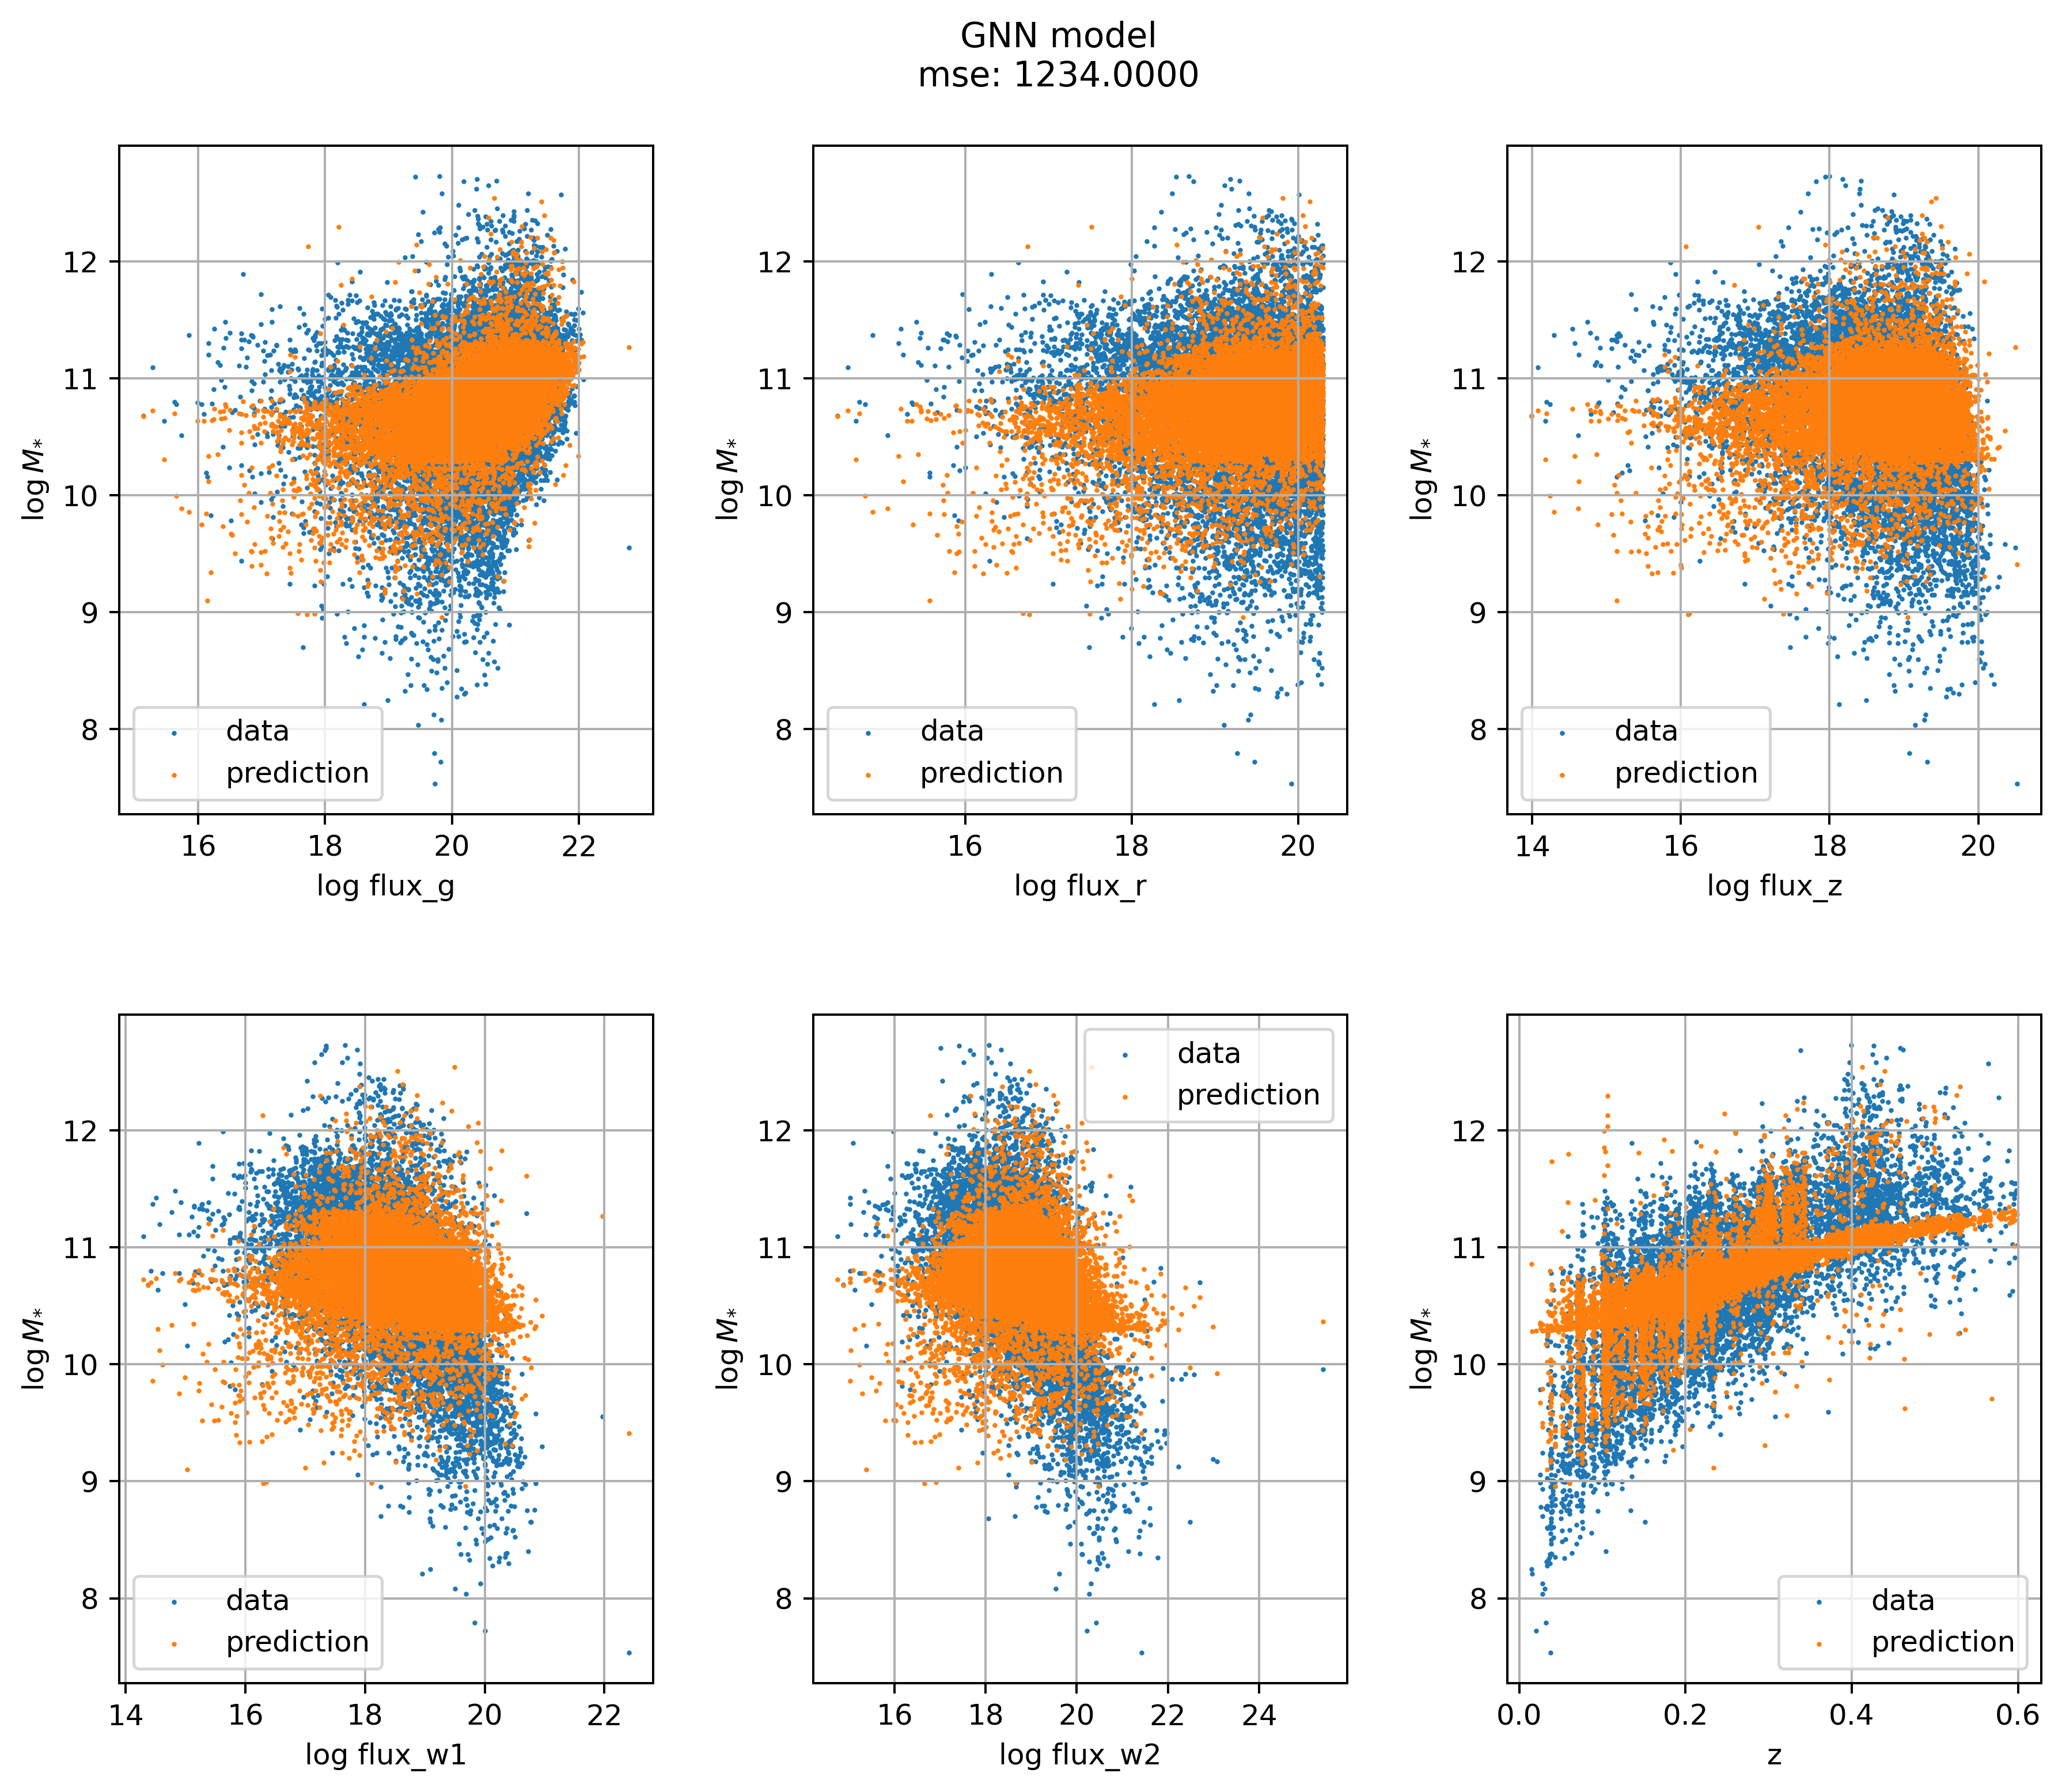

In [51]:
nrows, ncols = 3, 2
fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(10, 8))
plt.tight_layout()
plt.suptitle(f'GNN model\nmse: {1234:.4f}', y=1.05)
plt.subplots_adjust(wspace=0.3, hspace=0.3)

nodes, _, mass = graph_r(rosettes[0])
nodes = np.array(nodes)[:,1:]

for i in range(ncols):
    for j in range(nrows):
        axes[i, j].scatter(nodes[:,i*3+j], mass, s=0.5, label='data')
        axes[i, j].scatter(nodes[:,i*3+j], pred, s=0.5, label='prediction')
        axes[i, j].legend()
        axes[i, j].set_ylabel(r'$\log M_{*}$')
        axes[i, j].set_xlabel(f'{props[i*3+j]}')
        axes[i, j].grid()

plt.show()